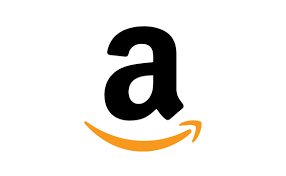
<h2 style="font-face: verdana; font-size: 32px;">Amazon Reviews</h2>
<h3 style="font-face: verdana; font-size: 16px;">Derive rich features for Machine Learning with the Watson Cognitive APIs</h3>
<br><br>

<h3 style="font-face: verdana; font-size: 16px;">The objective of this machine learning model is to predict the rating a user would give a product based on his or her customer review.</h3>

The dataset contains the ID of the reviewer, the product ID, the reviewer's name, a helpfulness rating of the review by other users, the review text, an overall rating of the product, a summary of the review and the time of the review. In this machine learning model, we will only be using the review text and the user's overall rating of the product.
<br><br>

Data fields in the dataset:


    reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
    asin - ID of the product, e.g. 0000013714
    reviewerName - name of the reviewer
    helpful - helpfulness rating of the review, e.g. 2/3
    reviewText - text of the review
    overall - rating of the product
    summary - summary of the review
    unixReviewTime - time of the review (unix time)
    reviewTime - time of the review (raw)

<br><br>
<img src="https://github.com/hackerguy/Amazon/blob/master/SampleReview.jpg?raw=true/">
<br><br>

<h3 style="font-face: verdana; font-size: 16px;">Approach</h3>

We will approach this challenge by first using a traditional multiclassification machine learning approach. We will then explore using IBM Watson Natural Language Understanding to derive additional enhanced features on which to learn a machine learning model.

<h3 style="font-face: verdana; font-size: 16px;">IBM Watson Natural Language Understanding</h3>

IBM Watson™ Natural Language Understanding (NLU) can analyze semantic features of text input, including categories, concepts, emotion, entities, keywords, metadata, relations, semantic roles, and sentiment. In this example, we will utilize the emotion and sentiment features of NLU to create enhanced machine learning features.


<h4 style="font-face: verdana; font-size: 16px;">Emotion</h4>

The emotion feature of NLU allows you to analyze emotion conveyed by specific target phrases or by the document as a whole. You can also enable emotion analysis for entities and keywords that are automatically detected by the service. In this example, we will simply analyze the spooky excerpt as a whole. The emotions we will derive features for are 

- Anger
- Joy
- Sadness
- Fear
- Disgust

Emotion scores range from 0 to 1 for sadness, joy, fear, disgust, and anger. A 0 means the text doesn't convey the emotion, and a 1 means the text definitely carries the emotion.

<h4 style="font-face: verdana; font-size: 16px;">Sentiment</h4>

The sentiment feature of NLU allows you to analyze the sentiment toward specific target phrases and the sentiment of the document as a whole. You can also get sentiment information for detected entities and keywords by enabling the sentiment option for those features. In this example, we will simply analyze the review text as a whole.

The sentiment score ranges from -1 (negative sentiment) to 1 (positive sentiment).



# Notebook Flow


**Part 1: [Traditional Machine Learning](#Part-1:-Traditional-Machine-Learning)**
  1. [Read in the Data](#1.-Read-in-the-Data)<br>
  2. [Clean the Data](#2.-Clean-the-Data)<br>
  3. [Feature Engineering](#3.-Feature-Engineering)<br>
  4. [Build ML Pipeline and Learn a Model](#4.-Build-ML-Pipeline-and-Learn-a-Model)<br>
  5. [Evaluate the Model](#5.-Evaluate-the-Model)
    
**Part 2: [Machine Learning using Watson Cognitive APIs](#Part-2:-Machine-Learning-using-Watson-Cognitive-APIs)**
  1. [Set up for Use of the Natural Language Understanding Service](#1.-Set-up-for-Use-of-the-Natural-Language-Understanding-Service)<br>
  2. [Create Enhanced Features using the NLU Service](#2.-Create-Enhanced-Features-using-the-NLU-Service)<br>
  3. [Retrain Model with NLU Features Added](#3.-Retrain-Model-with-NLU-Features-Added)
  4. [Evaluate the Model Learned with NLU Features](#4.-Evaluate-the-Model-Learned-with-NLU-Features)


# Part 1: Traditional Machine Learning

This section will employ a traditional multiclassification machine learning approach to learning a model.

## 1. Read in the Data

### Download and unzip the dataset

In [1]:
import os
if os.path.isfile('reviews_Patio_Lawn_and_Garden_5.gz'):
    os.remove("reviews_Patio_Lawn_and_Garden_5.gz")
if os.path.isfile('reviews_Patio_Lawn_and_Garden_5.json'):
    os.remove("reviews_Patio_Lawn_and_Garden_5.json")

import wget
url = 'https://github.com/hackerguy/Amazon/blob/master/reviews_Patio_Lawn_and_Garden_5.gz?raw=true?raw=true -O reviews_Patio_Lawn_and_Garden_5.json'
wget.download(url)

import gzip
with gzip.open('reviews_Patio_Lawn_and_Garden_5.gz', 'rb') as f:
    file_content = f.read() 

file = open('reviews_Patio_Lawn_and_Garden_5.json','w') 
file.write(file_content) 
file.close() 

### Read in the data set as a Spark DataFrame
#### Infer schema and column names

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

data = (spark.read
  .format('json')
  .option("inferSchema", "true")
  .load('reviews_Patio_Lawn_and_Garden_5.json'))

### Display the dataframe

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
data.toPandas().head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002N674,"[4, 4]",4,"Good USA company that stands behind their products. I have had to warranty two hoses and they send replacements right out to you. I had one burst after awhile, you could see it buldge for weeks before it went so no suprises. The other one was winter related as I am bad and leave them out most of the time. Highly reccomend. Note the hundred footer is heavy and like wresting an anaconda when its time to put away, but it does have a far reach.","06 21, 2011",A1JZFGZEZVWQPY,"Carter H ""1amazonreviewer@gmail . com""",Great Hoses,1308614400
1,B00002N674,"[0, 0]",5,This is a high quality 8 ply hose. I have had good luck with Gilmour hoses in the past. A good choice in hoses.,"06 9, 2014",A32JCI4AK2JTTG,"Darryl Bennett ""Fuzzy342""","Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch by 50-Foot, Green",1402272000
2,B00002N674,"[2, 3]",4,"It's probably one of the best hoses I've ever had.Pro's:- It's good enough for most front yards, or small back yards.- It has enough flow (and with the right head) to water plants 25ft away from the nozzle, and water your garden.- It's light weight, and flexible (it does not pose as much of a problem unrolling this hose with kinks as with other hoses I've owned)- The hose is flexible, yet strong. I haven't cut the outside yet.- This hose has been in full sunlight for more than 3 months, and the rubber hasn't cracked yet! I believe it's good quality rubber.cons:- Like with every hose, keeping it outside in the sunshine, the water warms up and starts smelling.My dog don't want to drink from the water coming from this hose.- The hose is only in one color (I wished it was a little less visible in the gardenOtherwise this hose is an excellent garden tool!I bought 2 of them, one 25ft for my front garden, and 50ft for my rear garden.3-4months and still in excellent condition!","05 5, 2012",A3N0P5AAMP6XD2,H B,Very satisfied!,1336176000
3,B00002N674,"[0, 0]",5,"I probably should have bought something a bit more flexible and less rugged since I constantly coil/uncoil it for washing cars, but that's my fault not a product fault.","07 15, 2013",A2QK7UNJ857YG,Jason,Very high quality,1373846400
4,B00002N674,"[1, 1]",5,"I bought three of these 5/8-inch Flexogen hoses--50, 75, and 100 feet--for different areas of yard around the house. After a season of use they've proven to be good hoses. Of course, it's very favorable that they don't leak. But what particularly impresses me about them is their notably light weight and flexibility, which make them a lot easier to handle than my previous hoses. The flexibility diminishes in cold weather, but a garden hose is less useful then anyway.They're not especially prone to kinking, but they're not kink-proof, either, nor do they claim to be. They kink a lot less than one of my old hoses and more than a couple of others, but the latter were fairly stiff, so there was a trade-off.Bottom line: this was a good purchase.","08 5, 2013",AS0CYBAN6EM06,jimmy,Good Hoses,1375660800


### Drop all but the text and overall rating columns and rename the text review column

In [4]:
data = data.select('reviewText', 'overall')
data = data.withColumnRenamed('reviewText', 'text')

### Show the schema of the data including data types

In [5]:
data.printSchema()

root
 |-- text: string (nullable = true)
 |-- overall: double (nullable = true)



### Dataset Overview - number of rows and columns

In [6]:
print("There are {} rows in the dataset.".format(str(data.count())))
print("There are {} columns in the dataset.".format(str(len(data.columns))))

There are 13272 rows in the dataset.
There are 2 columns in the dataset.


## 2. Clean the Data

### Drop any rows with null values

In [7]:
data = data.na.drop()
print("There are {} rows in the dataset.".format(str(data.count())))
print("There are {} columns in the dataset.".format(str(len(data.columns))))

There are 13272 rows in the dataset.
There are 2 columns in the dataset.


### Convert numerical rating into positive (1.0) score if overall rating is a 4 or 5 and a negative (0.0) score if the overall rating is a 1, 2 or 3

In [8]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
udf = udf(lambda overall: 1.0 if overall > 3 else 0.0, FloatType())

In [9]:
data = (data.withColumn('label', udf(data['overall'])))

In [10]:
data.select('overall', 'label').sample(False, 0.1, 1).toPandas().head()

,overall,label
0,4,1
1,5,1
2,5,1
3,2,0
4,3,0


### Drop the original overall rating column

In [11]:
data = data.drop('overall')
data.sample(False, 0.1, 1).toPandas().head()

text  \
0  It's probably one of the best hoses I've ever had.Pro's:- It's good enough for most front yards, or small back yards.- It has enough flow (and with the right head) to water plants 25ft away from the nozzle, and water your garden.- It's light weight, and flexible (it does not pose as much of a problem unrolling this hose with kinks as with other hoses I've owned)- The hose is flexible, yet strong. I haven't cut the outside yet.- This hose has been in full sunlight for more than 3 months, and the rubber hasn't cracked yet! I believe it's good quality rubber.cons:- Like with every hose, keeping it outside in the sunshine, the water warms up and starts smelling.My dog don't want to drink from the water coming from this hose.- The hose is only in one color (I wished it was a little less visible in the gardenOtherwise this hose is an excellent garden tool!I bought 2 of them, one 25ft for my front garden, and 50ft for my rear garden.3-4months and still in excellent condition!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Balance the data label values and use a subset of the data for processing efficiency

In [12]:
# print('The number of records in the original data set is {}.'.format(data.count()))
data0count = data.filter(data['label'] == 0.0).count()
data1count = data.filter(data['label'] == 1.0).count()
print('The number of rows labeled 0.0 in the original data set is {}.'.format(data0count))
print('The number of rows labeled 1.0 in the original data set is {}.'.format(data1count))

The number of rows labeled 0.0 in the original data set is 2851.
The number of rows labeled 1.0 in the original data set is 10421.


In [13]:
import brunel
dist = {'value' : ["zero", "one"],
        'count' : [data0count, data1count]}
dist = pd.DataFrame.from_dict(dist)
%brunel data('dist') bar x(value) y(count) title("Distribution of Label Values") :: width=1100, height=400 

<IPython.core.display.Javascript object>

In [14]:
# Set a limit to the number of rows associated with each label
limit = 200

In [15]:
data = data.sample(False, 0.1, 0)
data0 = data.filter(data['label'] == 0.0).limit(limit)
data1 = data.filter(data['label'] == 1.0).limit(limit)
data = data0.union(data1)

In [16]:
print('The number of records in the data set is now {}.'.format(data.count()))
data0count = data.filter(data['label'] == 0.0).count()
data1count = data.filter(data['label'] == 1.0).count()
print('The number of rows labeled 0.0 in the data set is now {}.'.format(data0count))
print('The number of rows labeled 1.0 in the data set is now {}.'.format(data1count))

The number of records in the data set is now 400.
The number of rows labeled 0.0 in the data set is now 200.
The number of rows labeled 1.0 in the data set is now 200.


In [17]:
dist = {'value' : ["zero", "one"],
        'count' : [data0count, data1count]}
dist = pd.DataFrame.from_dict(dist)
%brunel data('dist') bar x(value) y(count) title("Distribution of Label Values") :: width=1100, height=400 

<IPython.core.display.Javascript object>

### Remove punctuation from the text

In [18]:
from pyspark.ml.feature import SQLTransformer
removePunctuationTrans = SQLTransformer(
    statement="""SELECT *, TRANSLATE(text,',.:;!?@#$%^&*()+=-`~{}[]|\/''"<>','') AS textNoPunctuation FROM __THIS__""")
data = removePunctuationTrans.transform(data)
data.select('text', 'textNoPunctuation').toPandas().head()

,text,textNoPunctuation
0,"I remember my dad using a sprinkler like this when I was a kid (I'm 61). We are in the middle of a drought here in Texas and I was tired of having to move the sprinkler and thought this would solve my problem. First of all, this is a VERY heavy sprinkler and is awkward to pick up and move. If you have any trouble lifting heavy objects, get something else. It has to be moved. You can't drag it and you can't turn it around and make it go the other direction. I have found I have to check on it as often, if not more often, than I was moving my oscillating sprinkler. First, it jumped off the hose/track and was climbing the fence. Then, it kinked the hose and cut off the water. Finally, it dug itself a hole and had mud all over the back wheels. Tried it another time and it just stopped spraying water. No kink this time, checked the button on the bottom, couldn't get it going again. I went back to my oscillating sprinkler. At least it's easy to move around. I think you need to use this on a very flat, very straight lawn. Mine is bumpy and I need it to make a couple of gentle curves. It didn't work for me. I like the spray it puts out and would use it as a stationery sprinkler if it weren't so heavy to move.",I remember my dad using a sprinkler like this when I was a kid I'm 61 We are in the middle of a drought here in Texas and I was tired of having to move the sprinkler and thought this would solve my problem First of all this is a VERY heavy sprinkler and is awkward to pick up and move If you have any trouble lifting heavy objects get something else It has to be moved You can't drag it and you can't turn it around and make it go the other direction I have found I have to check on it as often if not more often than I was moving my oscillating sprinkler First it jumped off the hosetrack and was climbing the fence Then it kinked the hose and cut off the water Finally it dug itself a hole and had mud all over the back wheels Tried it another time and it just stopped spraying water No kink this time checked the button on the bottom couldn't get it going again I went back to my oscillating sprinkler At least it's easy to move around I think you need to use this on a very flat very straight lawn Mine is bumpy and I need it to make a couple of gentle curves It didn't work for me I like the spray it puts out and would use it as a stationery sprinkler if it weren't so heavy to move
1,"I purchased 6 of these hoses with what was supposed to be a lifetime guarantee. After a short time, the end on one of the hoses started leaking so I contacted the manufacturer and got a replacement. A year later another hose started leaking and I got another replacement. Then another hose started leaking but the company would no longer honor the warranty! Now Gilmour is selling them. But it's the same hose - ""Flexogen"". The hose itself it actually quite good if you don't mind replacing the hose ends eventually, I've had to replace every end on every Flexogen hose that I have.Keep in mind that I bought hoses from Flexogen but that company no longer exists and Gilmour would not honor the warranty on those hoses even though Gilmour is now selling them. Also note that Flexogen is a patented hose. Lifetime warranty isn't much good when the company gets bought or taken over by another company and the new company (Gilmour) won't honor the warranty. And who wants to have to keep sending in hose parts to get a replacement every year or two.Let me reiterate, Gilmour would not honor the warranty on my Flexogen hoses. I wrote to them multiple times and was told (without explanation) that Gilmour would not replace the defective hoses. If you buy these hoses expecting a lifetime warranty, you may not get it.On the Gilmour website, there is no longer any information relating to Flexogen hose warranty or on how to have a Flexogen hose replaced. On Amazon, it does say ""This heavy-duty garden hose is made in the USA and backed by a lifetime guarante

In [19]:
data = data.drop('text').withColumnRenamed('textNoPunctuation', 'text')
data.toPandas().head()

,label,text
0,0,I remember my dad using a sprinkler like this when I was a kid I'm 61 We are in the middle of a drought here in Texas and I was tired of having to move the sprinkler and thought this would solve my problem First of all this is a VERY heavy sprinkler and is awkward to pick up and move If you have any trouble lifting heavy objects get something else It has to be moved You can't drag it and you can't turn it around and make it go the other direction I have found I have to check on it as often if not more often than I was moving my oscillating sprinkler First it jumped off the hosetrack and was climbing the fence Then it kinked the hose and cut off the water Finally it dug itself a hole and had mud all over the back wheels Tried it another time and it just stopped spraying water No kink this time checked the button on the bottom couldn't get it going again I went back to my oscillating sprinkler At least it's easy to move around I think you need to use this on a very flat very straight lawn Mine is bumpy and I need it to make a couple of gentle curves It didn't work for me I like the spray it puts out and would use it as a stationery sprinkler if it weren't so heavy to move
1,0,I purchased 6 of these hoses with what was supposed to be a lifetime guarantee After a short time the end on one of the hoses started leaking so I contacted the manufacturer and got a replacement A year later another hose started leaking and I got another replacement Then another hose started leaking but the company would no longer honor the warranty Now Gilmour is selling them But it's the same hose Flexogen The hose itself it actually quite good if you don't mind replacing the hose ends eventually I've had to replace every end on every Flexogen hose that I haveKeep in mind that I bought hoses from Flexogen but that company no longer exists and Gilmour would not honor the warranty on those hoses even though Gilmour is now selling them Also note that Flexogen is a patented hose Lifetime warranty isn't much good when the company gets bought or taken over by another company and the new company Gilmour won't honor the warranty And who wants to have to keep sending in hose parts to get a replacement every year or twoLet me reiterate Gilmour would not honor the warranty on my Flexogen hoses I wrote to them multiple times and was told without explanation that Gilmour would not replace the defective hoses If you buy these hoses expecting a lifetime warranty you may not get itOn the Gilmour website there is no longer any information relating to Flexogen hose warranty or on how to have a Flexogen hose replaced On Amazon it does say This heavyduty garden hose is made in the USA and backed by a lifetime guarantee It also says Lifetime Guarantee on the front of the hose package Gilmour is now owned by the Robert Bosch Corp so probably even less chance of getting a warranty replacement
2,0,The bee guards worked great but the reason I gave it only three stars is the price Over a buck a piece is more than it should be in my option If it wasn't a gift to my dad who enjoys his hummingbirds I would have kept looking for a cheaper place to purchase them
3,0,I read the other reviewers who had similar problems before I bought this I also read the reviews raving about this hose Since these hoses are maid from remnants I suppose its a matter of luck as to which hose you get My luck wasn't good The hose had permanent kinks and the vinyl skin had bubbles where it was separating from the hoseReturned it immediately
4,0,Am writing this while cooking some chicken on a WSJ i found last week in new condition for a Hamilton Let me preface my comments by stating that I have a 22inch Weber with hinged grate that I loveThe WSJ is small somewhat solidly constructed mine while unused has rust rings around the handle welds that go through the cover not goodHowever most folks use this Weber as a portable grill Weber for gawd's sakes incorporate some form of simple mechanism ON A

## 3. Feature Engineering

### Tokenize the text

In [20]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol="text", outputCol="words")

countTokens = udf(lambda words: len(words), IntegerType())

tokenized = tokenizer.transform(data)
(tokenized.select("text", "words")
    .withColumn("#tokens", countTokens(col("words"))).toPandas().head())

,text,words,#tokens
0,I remember my dad using a sprinkler like this when I was a kid I'm 61 We are in the middle of a drought here in Texas and I was tired of having to move the sprinkler and thought this would solve my problem First of all this is a VERY heavy sprinkler and is awkward to pick up and move If you have any trouble lifting heavy objects get something else It has to be moved You can't drag it and you can't turn it around and make it go the other direction I have found I have to check on it as often if not more often than I was moving my oscillating sprinkler First it jumped off the hosetrack and was climbing the fence Then it kinked the hose and cut off the water Finally it dug itself a hole and had mud all over the back wheels Tried it another time and it just stopped spraying water No kink this time checked the button on the bottom couldn't get it going again I went back to my oscillating sprinkler At least it's easy to move around I think you need to use this on a very flat very straight lawn Mine is bumpy and I need it to make a couple of gentle curves It didn't work for me I like the spray it puts out and would use it as a stationery sprinkler if it weren't so heavy to move,"[i, remember, my, dad, using, a, sprinkler, like, this, when, i, was, a, kid, i'm, 61, , we, are, in, the, middle, of, a, drought, here, in, texas, and, i, was, tired, of, having, to, move, the, sprinkler, and, thought, this, would, solve, my, problem, , first, of, all, this, is, a, very, heavy, sprinkler, and, is, awkward, to, pick, up, and, move, , if, you, have, any, trouble, lifting, heavy, objects, get, something, else, , it, has, to, be, moved, , you, can't, drag, it, and, you, can't, turn, it, around, and, make, it, go, the, other, direction, , ...]",262
1,I purchased 6 of these hoses with what was supposed to be a lifetime guarantee After a short time the end on one of the hoses started leaking so I contacted the manufacturer and got a replacement A year later another hose started leaking and I got another replacement Then another hose started leaking but the company would no longer honor the warranty Now Gilmour is selling them But it's the same hose Flexogen The hose itself it actually quite good if you don't mind replacing the hose ends eventually I've had to replace every end on every Flexogen hose that I haveKeep in mind that I bought hoses from Flexogen but that company no longer exists and Gilmour would not honor the warranty on those hoses even though Gilmour is now selling them Also note that Flexogen is a patented hose Lifetime warranty isn't much good when the company gets bought or taken over by another company and the new company Gilmour won't honor the warranty And who wants to have to keep sending in hose parts to get a replacement every year or twoLet me reiterate Gilmour would not honor the warranty on my Flexogen hoses I wrote to them multiple times and was told without explanation that Gilmour would not replace the defective hoses If you buy these hoses expecting a lifetime warranty you may not get itOn the Gilmour website there is no longer any information relating to Flexogen hose warranty or on how to have a Flexogen hose replaced On Amazon it does say This heavyduty garden hose is made in the USA and backed by a lifetime guarantee It also says Lifetime Guarantee on the front of the hose package Gilmour is now owned by the Robert Bosch Corp so probably even less chance of getting a warranty replacement,"[i, purchased, 6, of, these, hoses, with, what, was, supposed, to, be, a, lifetime, guarantee, after, a, short, time, the, end, on, one, of, the, hoses, started, leaking, so, i, contacted, the, manufacturer, and, got, a, replacement, a, year, later, another, hose, started, leaking, and, i, got, another, replacement, then, another, hose, started, leaking, but, the, company, would, no, longer, honor, the, warranty, now, gilmour, is, selling, them, but, it's, the, same, hose, , flexogen, the, hose, itself, it, ac

### Remove common words

In [21]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="words", outputCol="filtered").setCaseSensitive(False)
removed = remover.transform(tokenized)
removed.select("text", "words", "filtered" ).toPandas().head()

,text,words,filtered
0,I remember my dad using a sprinkler like this when I was a kid I'm 61 We are in the middle of a drought here in Texas and I was tired of having to move the sprinkler and thought this would solve my problem First of all this is a VERY heavy sprinkler and is awkward to pick up and move If you have any trouble lifting heavy objects get something else It has to be moved You can't drag it and you can't turn it around and make it go the other direction I have found I have to check on it as often if not more often than I was moving my oscillating sprinkler First it jumped off the hosetrack and was climbing the fence Then it kinked the hose and cut off the water Finally it dug itself a hole and had mud all over the back wheels Tried it another time and it just stopped spraying water No kink this time checked the button on the bottom couldn't get it going again I went back to my oscillating sprinkler At least it's easy to move around I think you need to use this on a very flat very straight lawn Mine is bumpy and I need it to make a couple of gentle curves It didn't work for me I like the spray it puts out and would use it as a stationery sprinkler if it weren't so heavy to move,"[i, remember, my, dad, using, a, sprinkler, like, this, when, i, was, a, kid, i'm, 61, , we, are, in, the, middle, of, a, drought, here, in, texas, and, i, was, tired, of, having, to, move, the, sprinkler, and, thought, this, would, solve, my, problem, , first, of, all, this, is, a, very, heavy, sprinkler, and, is, awkward, to, pick, up, and, move, , if, you, have, any, trouble, lifting, heavy, objects, get, something, else, , it, has, to, be, moved, , you, can't, drag, it, and, you, can't, turn, it, around, and, make, it, go, the, other, direction, , ...]","[remember, dad, using, sprinkler, like, kid, i'm, 61, , middle, drought, texas, tired, move, sprinkler, thought, would, solve, problem, , first, heavy, sprinkler, awkward, pick, move, , trouble, lifting, heavy, objects, get, something, else, , moved, , can't, drag, can't, turn, around, make, go, direction, , found, check, often, often, moving, oscillating, sprinkler, , first, jumped, hosetrack, climbing, fence, , kinked, hose, cut, water, , finally, dug, hole, mud, back, wheels, , tried, another, time, stopped, spraying, water, , kink, time, checked, button, bottom, couldn't, get, going, , went, back, oscillating, sprinkler, , least, it's, easy, move, around, , think, ...]"
1,I purchased 6 of these hoses with what was supposed to be a lifetime guarantee After a short time the end on one of the hoses started leaking so I contacted the manufacturer and got a replacement A year later another hose started leaking and I got another replacement Then another hose started leaking but the company would no longer honor the warranty Now Gilmour is selling them But it's the same hose Flexogen The hose itself it actually quite good if you don't mind replacing the hose ends eventually I've had to replace every end on every Flexogen hose that I haveKeep in mind that I bought hoses from Flexogen but that company no longer exists and Gilmour would not honor the warranty on those hoses even though Gilmour is now selling them Also note that Flexogen is a patented hose Lifetime warranty isn't much good when the company gets bought or taken over by another company and the new company Gilmour won't honor the warranty And who wants to have to keep sending in hose parts to get a replacement every year or twoLet me reiterate Gilmour would not honor the warranty on my Flexogen hoses I wrote to them multiple times and was told without explanation that Gilmour would not replace the defective hoses If you buy these hoses expecting a lifetime warranty you may not get itOn the Gilmour website there is no longer any information relating to Flexogen hose warranty or on how to have a Flexogen hose replaced On Amazon it does say This heavyduty garden hose is made in the USA and backed by a lifetime guarantee It also s

### Show list of common words removed

In [22]:
from __future__ import print_function
[print(x) for x in remover.getStopWords()]

i
me
my
myself
we
our
ours
ourselves
you
your
yours
yourself
yourselves
he
him
his
himself
she
her
hers
herself
it
its
itself
they
them
their
theirs
themselves
what
which
who
whom
this
that
these
those
am
is
are
was
were
be
been
being
have
has
had
having
do
does
did
doing
a
an
the
and
but
if
or
because
as
until
while
of
at
by
for
with
about
against
between
into
through
during
before
after
above
below
to
from
up
down
in
out
on
off
over
under
again
further
then
once
here
there
when
where
why
how
all
any
both
each
few
more
most
other
some
such
no
nor
not
only
own
same
so
than
too
very
s
t
can
will
just
don
should
now
d
ll
m
o
re
ve
y
ain
aren
couldn
didn
doesn
hadn
hasn
haven
isn
ma
mightn
mustn
needn
shan
shouldn
wasn
weren
won
wouldn


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Hash the words

In [23]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=100)
featurizedData = hashingTF.transform(removed)
featurizedData.select("text", "filtered", "rawFeatures").toPandas().head()

,text,filtered,rawFeatures
0,I remember my dad using a sprinkler like this when I was a kid I'm 61 We are in the middle of a drought here in Texas and I was tired of having to move the sprinkler and thought this would solve my problem First of all this is a VERY heavy sprinkler and is awkward to pick up and move If you have any trouble lifting heavy objects get something else It has to be moved You can't drag it and you can't turn it around and make it go the other direction I have found I have to check on it as often if not more often than I was moving my oscillating sprinkler First it jumped off the hosetrack and was climbing the fence Then it kinked the hose and cut off the water Finally it dug itself a hole and had mud all over the back wheels Tried it another time and it just stopped spraying water No kink this time checked the button on the bottom couldn't get it going again I went back to my oscillating sprinkler At least it's easy to move around I think you need to use this on a very flat very straight lawn Mine is bumpy and I need it to make a couple of gentle curves It didn't work for me I like the spray it puts out and would use it as a stationery sprinkler if it weren't so heavy to move,"[remember, dad, using, sprinkler, like, kid, i'm, 61, , middle, drought, texas, tired, move, sprinkler, thought, would, solve, problem, , first, heavy, sprinkler, awkward, pick, move, , trouble, lifting, heavy, objects, get, something, else, , moved, , can't, drag, can't, turn, around, make, go, direction, , found, check, often, often, moving, oscillating, sprinkler, , first, jumped, hosetrack, climbing, fence, , kinked, hose, cut, water, , finally, dug, hole, mud, back, wheels, , tried, another, time, stopped, spraying, water, , kink, time, checked, button, bottom, couldn't, get, going, , went, back, oscillating, sprinkler, , least, it's, easy, move, around, , think, ...]","(1.0, 5.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 3.0, 2.0, 7.0, 1.0, 1.0, 0.0, 4.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 5.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 1.0, 4.0, 0.0, 5.0, 0.0, 3.0, 1.0, 3.0, 3.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 18.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 7.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0)"
1,I purchased 6 of these hoses with what was supposed to be a lifetime guarantee After a short time the end on one of the hoses started leaking so I contacted the manufacturer and got a replacement A year later another hose started leaking and I got another replacement Then another hose started leaking but the company would no longer honor the warranty Now Gilmour is selling them But it's the same hose Flexogen The hose itself it actually quite good if you don't mind replacing the hose ends eventually I've had to replace every end on every Flexogen hose that I haveKeep in mind that I bought hoses from Flexogen but that company no longer exists and Gilmour would not honor the warranty on those hoses even though Gilmour is now selling them Also note that Flexogen is a patented hose Lifetime warranty isn't much good when the company gets bought or taken over by another company and the new company Gilmour won't honor the warranty And who wants to have to keep sending in hose parts to get a replacement every year or twoLet me reiterate Gilmour would not honor the warranty on my Flexogen hoses I wrote to them multiple times and was told without explanation that Gilmour would not replace the defective hoses If you buy these hoses expecting a lifetime warranty you may not get itOn the Gilmour website there is no longer any information relating to Flexogen hose warranty or on how to have a Flexogen hose replaced On Amazon it does say This heavyduty garden hose is made in the USA and backed by a lifetime guarantee It also says Lifetime Guarantee on the front of the hose package

### Inverse weight words that occur frequently across all text

In [24]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("text", "rawFeatures", "features").toPandas().head()

,text,rawFeatures,features
0,I remember my dad using a sprinkler like this when I was a kid I'm 61 We are in the middle of a drought here in Texas and I was tired of having to move the sprinkler and thought this would solve my problem First of all this is a VERY heavy sprinkler and is awkward to pick up and move If you have any trouble lifting heavy objects get something else It has to be moved You can't drag it and you can't turn it around and make it go the other direction I have found I have to check on it as often if not more often than I was moving my oscillating sprinkler First it jumped off the hosetrack and was climbing the fence Then it kinked the hose and cut off the water Finally it dug itself a hole and had mud all over the back wheels Tried it another time and it just stopped spraying water No kink this time checked the button on the bottom couldn't get it going again I went back to my oscillating sprinkler At least it's easy to move around I think you need to use this on a very flat very straight lawn Mine is bumpy and I need it to make a couple of gentle curves It didn't work for me I like the spray it puts out and would use it as a stationery sprinkler if it weren't so heavy to move,"(1.0, 5.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 3.0, 2.0, 7.0, 1.0, 1.0, 0.0, 4.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 5.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 1.0, 4.0, 0.0, 5.0, 0.0, 3.0, 1.0, 3.0, 3.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 18.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 7.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0)","(0.888015953406, 3.16334630799, 1.31183020018, 0.0, 0.0, 0.720961868743, 0.0, 0.0, 0.925057225086, 1.11876410411, 0.0, 1.01722768489, 0.0, 0.488629891374, 0.0, 0.0, 1.29348106151, 0.0, 0.888015953406, 1.10361229908, 0.762852810452, 0.0, 0.0, 0.0, 1.70703422948, 1.26533852319, 4.62869843829, 0.695644060759, 1.09612162736, 0.0, 2.47473207849, 0.817811694733, 0.0, 0.0, 1.81273018415, 0.852297870804, 0.925057225086, 2.28313580144, 0.98332613321, 0.0, 0.834906128092, 0.0, 0.806575621466, 1.0523190047, 0.0, 1.0103548056, 0.0, 0.840669832809, 2.58741558636, 0.0, 0.0, 0.0, 1.02414812773, 3.82803529957, 0.0, 3.78759732238, 0.0, 1.41750152833, 0.888015953406, 1.52749348145, 1.68071827126, 1.05948749418, 0.0, 1.18256809087, 1.34190289634, 0.829175453383, 0.0, 0.0, 0.0, 2.07626873941, 0.0, 0.937715621958, 5.10361937877, 0.0, 0.0, 0.0, 1.2403712362, 1.54721120446, 0.0, 1.65835090677, 0.840669832809, 0.0, 6.9772440748, 1.70459574161, 0.0, 1.05948749418, 1.64695486454, 0.0, 0.651627175342, 0.791078936616, 0.0, 0.0, 0.618683019622, 0.736466055279, 0.0, 0.0, 0.0, 0.894094999482, 0.990015121361, 0.912557062322)"
1,I purchased 6 of these hoses with what was supposed to be a lifetime guarantee After a short time the end on one of the hoses started leaking so I contacted the manufacturer and got a replacement A year later another hose started leaking and I got another replacement Then another hose started leaking but the company would no longer honor the warranty Now Gilmour is selling them But it's the same hose Flexogen The hose itself it actually quite good if you don't mind replacing the hose ends eventually I've had to replace every end on every Flexogen hose that I haveKeep in mind that I bought hoses from Flexogen but that company no longer exists and Gilmour would not honor the warranty on those hoses even though Gilmour is now selling them Also note that Flexogen is a patented hose Lifetime warranty isn't much good when the company gets bought or taken over by another company and the new company Gilmour won't honor the warranty And who wants to have to keep sending in hose parts to get a replacement every year or twoLet me reiterate Gilmour would not honor the warranty on my Flexogen hoses I wrote to them multiple times and was told without explanat

## 4. Build ML Pipeline and Learn a Model

### Use Logistic Regression Algorithm to predict author

In [25]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "label", regParam=0.0, threshold=0.5)

### Define the machine learning pipeline

In [26]:
stages = [removePunctuationTrans, tokenizer, remover, hashingTF, idf, lr]
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)

### Display the parameter setting of the pipeline stages

In [27]:
print("Remove Punctuation SQL Transformer:")
print(removePunctuationTrans.explainParams())
print("*************************")
print(tokenizer.explainParams())
print("*************************")
print("Tokenizer:")
print(tokenizer.explainParams())
print("*************************")
print("Remover:")
print(remover.explainParams())
print("*************************")
print("HashingTF:")
print(hashingTF.explainParams())
print("*************************")
print("IDF:")
print(idf.explainParams())
print("*************************")
print("LogisticRegression:")
print(lr.explainParams())
print("*************************")
print("Pipeline:")
print(pipeline.explainParams())

Remove Punctuation SQL Transformer:
statement: SQL statement (current: SELECT *, TRANSLATE(text,',.:;!?@#$%^&*()+=-`~{}[]|\/''"<>','') AS textNoPunctuation FROM __THIS__)
*************************
inputCol: input column name. (current: text)
outputCol: output column name. (default: Tokenizer_4bac89244f51345ae632__output, current: words)
*************************
Tokenizer:
inputCol: input column name. (current: text)
outputCol: output column name. (default: Tokenizer_4bac89244f51345ae632__output, current: words)
*************************
Remover:
caseSensitive: whether to do a case sensitive comparison over the stop words (default: False, current: False)
inputCol: input column name. (current: words)
outputCol: output column name. (default: StopWordsRemover_45d88334a8b0d2590bb6__output, current: filtered)
stopWords: The words to be filtered out (default: [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'

### Split the dataset into training and test data sets

In [28]:
train, test = data.randomSplit([70.0,30.0], seed=1)
print('The number of records in the training data set is {}.'.format(train.count()))
print('The number of rows labeled 0.0 in the training data set is {}.'.format(train.filter(train['label'] == 0.0).count()))
print('The number of rows labeled 1.0 in the training data set is {}.'.format(train.filter(train['label'] == 1.0).count()))
print("")
print('The number of records in the test data set is {}.'.format(test.count()))
print('The number of rows labeled 0.0 in the test data set is {}.'.format(test.filter(test['label'] == 0.0).count()))
print('The number of rows labeled 1.0 in the test data set is {}.'.format(test.filter(test['label'] == 1.0).count()))

The number of records in the training data set is 281.
The number of rows labeled 0.0 in the training data set is 142.
The number of rows labeled 1.0 in the training data set is 139.

The number of records in the test data set is 119.
The number of rows labeled 0.0 in the test data set is 58.
The number of rows labeled 1.0 in the test data set is 61.


### Train the model using the training data set

In [29]:
model = pipeline.fit(train)

## 5. Evaluate the Model

### Make predictions using the test data set

In [30]:
predictions = model.transform(test)

In [31]:
print('The number of rows with prediction of 0.0 is {}.'.format(predictions.filter(predictions['prediction'] == 0.0).count()))
print('The number of rows with prediction of 1.0 is {}.'.format(predictions.filter(predictions['prediction'] == 1.0).count()))

The number of rows with prediction of 0.0 is 53.
The number of rows with prediction of 1.0 is 66.


In [32]:
predictions.select('label', 'prediction', 'text').sample(False, 0.1, 1).toPandas().head()

,label,prediction,text
0,0,0,Can't even get the plastic screw on top to work to open it so you can get the peanut butter on it for bait The instructions are terrible just on the side of the box with pictures that don't help at all If you can't get that little plastic screw piece on top open so you can remove itthen the trap is worthless I even tried pliers yes I was turning it the right way it shows to turn it counter clock wise after many tries I decided to try to turn it the other way too still can't get that plug out to bait it What a waste of money it's way over priced to begin with for something that can only be used once I would never buy this productI also pushed on the little red trap door that the mice are suppose to go in well they'd better have been lifting weights because you have to push pretty hard to get it so they could get in they'd better be very tiny mice as the hole is about the size of a nickel As far as it trapping other secretionswe all live with those in our homes whether we see it smell it or taste it anyhow as far as I know unless you have a herd of mice it doesn't make you sick If you get sick it's because you don't clean your home clean your carpets annually when you have pets wash the floors once a week There are more germs spread by just flushing your toilet with the top up than any other item in your home puts in the air I'm extremely disappointed in this product
1,0,0,I bought this simply because of the reputation Havahart has The other Havahart traps I own like the 1025 is of top quality and made to last a lifetime When comparing the two it's as though they weren't even built by the same company This model is simply a joke The sides are so uneven I had to bend them in so that the doors would close without leaving a gaping escape hole I also had to bend the hatch bars because they would not fall into the fasteners when the hatch was triggered I did catch one mouse but without my straightening of the unit it would not have even been functional Note to ownersyou really need to read the instructions on how to adjust the sensitivity before you say it doesn't work That makes this unit NOT ready to use right out of the boxOther notesThere is no handle so you must be careful how you handle it so you don't get bit by the rodent The top corners are also razor sharp and you need to be careful not to get stabbed The corners should have been rounded off for the extra 10 in costIt is important to note that all traps must be cleaned with with bleach and then soap after a catch The urine and feces detracts other animals since they consider the trap marked Based on that point it is also important to know that cleaning this unit is painful as the windows are unfinished and act as a cheese grader on your hands Once again a few pennies should have been spent to finish off the rough edgesHavahart's build quality with this model is pretty disgraceful I wish the company would have thought twice before they permitted this costcutting AND let their quality control go down the drain
2,0,0,I have heard wonderful things about CO2 mosquito traps so I was thrilled to give this one a tryI can't even begin to tell you how frustrating my experience has been We followed the instructions and kept getting blinking red lights error notification We made several calls to customer service They were friendly and helpful but nothing solved the problemOne rep suggested using a brand new propane tank Eager to make it work we went out and bought a new tank That still didn't helpThe unit is worthless
3,0,1,Like to use my pressure washer in the garden and when I tested this concentrated thinking that just water does a nice job but thought a soap concentrate would cut the job in halfHonestly I did not see any striking improvement I was disappointed to say the least Thinking I did not use enough of the liquid I tried again Still did not notice any sparkling difference So have to say that I would not recommend this product
4,0,1,Ok being a man

### Evaluate the model performance by calculating the accuracy and the area under the ROC curve

In [33]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluatorMultiClass = MulticlassClassificationEvaluator(labelCol = "label", predictionCol="prediction").setMetricName("accuracy")
accuracy = evaluatorMultiClass.evaluate(predictions)*100
print('Accuracy = {:0.2f}%.'.format(accuracy))

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluatorBinary = BinaryClassificationEvaluator().setLabelCol("label").setMetricName("areaUnderROC")
areaROC = evaluatorBinary.evaluate(predictions)
print('Area under the ROC curve = {:0.2f}.'.format(areaROC))

Accuracy = 53.78%.
Area under the ROC curve = 0.57.


# Part 2: Machine Learning using Watson Cognitive APIs

This section will employ Watson Natrual Language Understanding to create rich features and learn a new model.

## 1. Set up for Use of the Natural Language Understanding Service

### Setup configuration for the Watson Natural Language Understanding (NLU) service

In [34]:
import watson_developer_cloud
from watson_developer_cloud import NaturalLanguageUnderstandingV1
import watson_developer_cloud.natural_language_understanding.features.v1 as Features
import json

In [35]:
NLU_USERNAME = 'cef50e9f-7a87-4346-8c2f-f77f5b18dc47'
NLU_PASSWORD = 'q3yX3dHMlQia'
natural_language_understanding = NaturalLanguageUnderstandingV1(
  username=NLU_USERNAME,
  password=NLU_PASSWORD,
  version="2017-02-27")

### Split up the dataframe - this will be important in order to limit the API call rate to the NLU Service

In [36]:
data00,data01,data02,data03,data04,data05,data06,data07,data08,data09,data10,data11,data12,data13,data14,data15,data16,data17,data18,data19, \
data20,data21,data22,data23,data24,data25,data26,data27,data28,data29,data30,data31,data32,data33,data34,data35,data36,data37,data38,data39, \
data40,data41,data42,data43,data44,data45,data46,data47,data48,data49,data50,data51,data52,data53,data54,data55,data56,data57,data58,data59, \
data60,data61,data62,data63,data64,data65,data66,data67,data68,data69,data70,data71,data72,data73,data74,data75,data76,data77,data78,data79, \
data80,data81,data82,data83,data84,data85,data86,data87,data88,data89,data90,data91,data92,data93,data94,data95,data96,data97,data98,data99 \
 = data.randomSplit([1.0]*100, 0)

### Show example of employing NLU API on single row of the data set

In [37]:
dataNLUtest = data00.select(data00["text"]).toJSON().collect()[0][8:-1]
print(dataNLUtest)
import json
features=[
    Features.Emotion(),
    Features.Sentiment()
  ]
nlu = natural_language_understanding.analyze(text=dataNLUtest, features=features, language='en', clean='true')
anger = nlu['emotion']['document']['emotion']['anger']
joy = nlu['emotion']['document']['emotion']['joy']
sadness = nlu['emotion']['document']['emotion']['sadness']
fear = nlu['emotion']['document']['emotion']['fear']
disgust = nlu['emotion']['document']['emotion']['disgust']
sentiment = nlu['sentiment']['document']['score']

print("")
print("Anger = {}".format(anger))
print("Joy = {}".format(joy))
print("Sadness = {}".format(sadness))
print("Fear = {}".format(fear))
print("Disgust = {}".format(disgust))
print("Sentiment = {}".format(sentiment))
print("")
print(json.dumps(nlu, indent=2))

"My wife has been struggling with a 58 50 foot hose for a long time I thought I'd surprise her with a lighter weight hose for her favorite gardening activity On first use the hose kinked We were both so disappointed Now she is faced with either returning to the old heavy hose or dealing with the kink problem"

Anger = 0.036255
Joy = 0.069136
Sadness = 0.859702
Fear = 0.077933
Disgust = 0.096842
Sentiment = -0.810266

{
  "usage": {
    "text_characters": 310, 
    "features": 2, 
    "text_units": 1
  }, 
  "emotion": {
    "document": {
      "emotion": {
        "anger": 0.036255, 
        "joy": 0.069136, 
        "sadness": 0.859702, 
        "fear": 0.077933, 
        "disgust": 0.096842
      }
    }
  }, 
  "language": "en", 
  "sentiment": {
    "document": {
      "score": -0.810266, 
      "label": "negative"
    }
  }
}


## 2. Create Enhanced Features using the NLU Service

### Define UDF to create NLU derived features

In [38]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
def udfNLU(text):
    try:
        return(json.dumps(NaturalLanguageUnderstandingV1(
        username=NLU_USERNAME, password=NLU_PASSWORD, version="2017-02-27")
        .analyze(text=text, features=features, clean='true')))
    except:
        pass
udfNLU = udf(udfNLU,StringType())

### Invoke UDF to create new column with NLU output

In [39]:
data00NLU = data00.withColumn('nlu', udfNLU(data00['text']))
data01NLU = data01.withColumn('nlu', udfNLU(data01['text']))
data02NLU = data02.withColumn('nlu', udfNLU(data02['text']))
data03NLU = data03.withColumn('nlu', udfNLU(data03['text']))
data04NLU = data04.withColumn('nlu', udfNLU(data04['text']))
data05NLU = data05.withColumn('nlu', udfNLU(data05['text']))
data06NLU = data06.withColumn('nlu', udfNLU(data06['text']))
data07NLU = data07.withColumn('nlu', udfNLU(data07['text']))
data08NLU = data08.withColumn('nlu', udfNLU(data08['text']))
data09NLU = data09.withColumn('nlu', udfNLU(data09['text']))
data10NLU = data10.withColumn('nlu', udfNLU(data10['text']))
data11NLU = data11.withColumn('nlu', udfNLU(data11['text']))
data12NLU = data12.withColumn('nlu', udfNLU(data12['text']))
data13NLU = data13.withColumn('nlu', udfNLU(data13['text']))
data14NLU = data14.withColumn('nlu', udfNLU(data14['text']))
data15NLU = data15.withColumn('nlu', udfNLU(data15['text']))
data16NLU = data16.withColumn('nlu', udfNLU(data16['text']))
data17NLU = data17.withColumn('nlu', udfNLU(data17['text']))
data18NLU = data18.withColumn('nlu', udfNLU(data18['text']))
data19NLU = data19.withColumn('nlu', udfNLU(data19['text']))
data20NLU = data20.withColumn('nlu', udfNLU(data20['text']))
data21NLU = data21.withColumn('nlu', udfNLU(data21['text']))
data22NLU = data22.withColumn('nlu', udfNLU(data22['text']))
data23NLU = data23.withColumn('nlu', udfNLU(data23['text']))
data24NLU = data24.withColumn('nlu', udfNLU(data24['text']))
data25NLU = data25.withColumn('nlu', udfNLU(data25['text']))
data26NLU = data26.withColumn('nlu', udfNLU(data26['text']))
data27NLU = data27.withColumn('nlu', udfNLU(data27['text']))
data28NLU = data28.withColumn('nlu', udfNLU(data28['text']))
data29NLU = data29.withColumn('nlu', udfNLU(data29['text']))
data30NLU = data30.withColumn('nlu', udfNLU(data30['text']))
data31NLU = data31.withColumn('nlu', udfNLU(data31['text']))
data32NLU = data32.withColumn('nlu', udfNLU(data32['text']))
data33NLU = data33.withColumn('nlu', udfNLU(data33['text']))
data34NLU = data34.withColumn('nlu', udfNLU(data34['text']))
data35NLU = data35.withColumn('nlu', udfNLU(data35['text']))
data36NLU = data36.withColumn('nlu', udfNLU(data36['text']))
data37NLU = data37.withColumn('nlu', udfNLU(data37['text']))
data38NLU = data38.withColumn('nlu', udfNLU(data38['text']))
data39NLU = data39.withColumn('nlu', udfNLU(data39['text']))
data40NLU = data40.withColumn('nlu', udfNLU(data40['text']))
data41NLU = data41.withColumn('nlu', udfNLU(data41['text']))
data42NLU = data42.withColumn('nlu', udfNLU(data42['text']))
data43NLU = data43.withColumn('nlu', udfNLU(data43['text']))
data44NLU = data44.withColumn('nlu', udfNLU(data44['text']))
data45NLU = data45.withColumn('nlu', udfNLU(data45['text']))
data46NLU = data46.withColumn('nlu', udfNLU(data46['text']))
data47NLU = data47.withColumn('nlu', udfNLU(data47['text']))
data48NLU = data48.withColumn('nlu', udfNLU(data48['text']))
data49NLU = data49.withColumn('nlu', udfNLU(data49['text']))
data50NLU = data50.withColumn('nlu', udfNLU(data50['text']))
data51NLU = data51.withColumn('nlu', udfNLU(data51['text']))
data52NLU = data52.withColumn('nlu', udfNLU(data52['text']))
data53NLU = data53.withColumn('nlu', udfNLU(data53['text']))
data54NLU = data54.withColumn('nlu', udfNLU(data54['text']))
data55NLU = data55.withColumn('nlu', udfNLU(data55['text']))
data56NLU = data56.withColumn('nlu', udfNLU(data56['text']))
data57NLU = data57.withColumn('nlu', udfNLU(data57['text']))
data58NLU = data58.withColumn('nlu', udfNLU(data58['text']))
data59NLU = data59.withColumn('nlu', udfNLU(data59['text']))
data60NLU = data60.withColumn('nlu', udfNLU(data60['text']))
data61NLU = data61.withColumn('nlu', udfNLU(data61['text']))
data62NLU = data62.withColumn('nlu', udfNLU(data62['text']))
data63NLU = data63.withColumn('nlu', udfNLU(data63['text']))
data64NLU = data64.withColumn('nlu', udfNLU(data64['text']))
data65NLU = data65.withColumn('nlu', udfNLU(data65['text']))
data66NLU = data66.withColumn('nlu', udfNLU(data66['text']))
data67NLU = data67.withColumn('nlu', udfNLU(data67['text']))
data68NLU = data68.withColumn('nlu', udfNLU(data68['text']))
data69NLU = data69.withColumn('nlu', udfNLU(data69['text']))
data70NLU = data70.withColumn('nlu', udfNLU(data70['text']))
data71NLU = data71.withColumn('nlu', udfNLU(data71['text']))
data72NLU = data72.withColumn('nlu', udfNLU(data72['text']))
data73NLU = data73.withColumn('nlu', udfNLU(data73['text']))
data74NLU = data74.withColumn('nlu', udfNLU(data74['text']))
data75NLU = data75.withColumn('nlu', udfNLU(data75['text']))
data76NLU = data76.withColumn('nlu', udfNLU(data76['text']))
data77NLU = data77.withColumn('nlu', udfNLU(data77['text']))
data78NLU = data78.withColumn('nlu', udfNLU(data78['text']))
data79NLU = data79.withColumn('nlu', udfNLU(data79['text']))
data80NLU = data80.withColumn('nlu', udfNLU(data80['text']))
data81NLU = data81.withColumn('nlu', udfNLU(data81['text']))
data82NLU = data82.withColumn('nlu', udfNLU(data82['text']))
data83NLU = data83.withColumn('nlu', udfNLU(data83['text']))
data84NLU = data84.withColumn('nlu', udfNLU(data84['text']))
data85NLU = data85.withColumn('nlu', udfNLU(data85['text']))
data86NLU = data86.withColumn('nlu', udfNLU(data86['text']))
data87NLU = data87.withColumn('nlu', udfNLU(data87['text']))
data88NLU = data88.withColumn('nlu', udfNLU(data88['text']))
data89NLU = data89.withColumn('nlu', udfNLU(data89['text']))
data90NLU = data90.withColumn('nlu', udfNLU(data90['text']))
data91NLU = data91.withColumn('nlu', udfNLU(data91['text']))
data92NLU = data92.withColumn('nlu', udfNLU(data92['text']))
data93NLU = data93.withColumn('nlu', udfNLU(data93['text']))
data94NLU = data94.withColumn('nlu', udfNLU(data94['text']))
data95NLU = data95.withColumn('nlu', udfNLU(data95['text']))
data96NLU = data96.withColumn('nlu', udfNLU(data96['text']))
data97NLU = data97.withColumn('nlu', udfNLU(data97['text']))
data98NLU = data98.withColumn('nlu', udfNLU(data98['text']))
data99NLU = data99.withColumn('nlu', udfNLU(data99['text']))

In [40]:
dataNLU= (data00NLU.union(data01NLU).union(data02NLU).union(data03NLU).union(data04NLU).union(data05NLU).union(data06NLU).union(data07NLU).union(data08NLU).union(data09NLU)
            .union(data10NLU).union(data11NLU).union(data12NLU).union(data13NLU).union(data14NLU).union(data15NLU).union(data16NLU).union(data17NLU).union(data18NLU).union(data19NLU)
            .union(data20NLU).union(data21NLU).union(data22NLU).union(data23NLU).union(data24NLU).union(data25NLU).union(data26NLU).union(data27NLU).union(data28NLU).union(data29NLU)
            .union(data30NLU).union(data31NLU).union(data32NLU).union(data33NLU).union(data34NLU).union(data35NLU).union(data36NLU).union(data37NLU).union(data38NLU).union(data39NLU)
            .union(data40NLU).union(data41NLU).union(data42NLU).union(data43NLU).union(data44NLU).union(data45NLU).union(data46NLU).union(data47NLU).union(data48NLU).union(data49NLU)
            .union(data50NLU).union(data51NLU).union(data52NLU).union(data53NLU).union(data54NLU).union(data55NLU).union(data56NLU).union(data57NLU).union(data58NLU).union(data59NLU)
            .union(data60NLU).union(data61NLU).union(data62NLU).union(data63NLU).union(data64NLU).union(data65NLU).union(data66NLU).union(data67NLU).union(data68NLU).union(data69NLU)
            .union(data70NLU).union(data71NLU).union(data72NLU).union(data73NLU).union(data74NLU).union(data75NLU).union(data76NLU).union(data77NLU).union(data78NLU).union(data79NLU)
            .union(data80NLU).union(data81NLU).union(data82NLU).union(data83NLU).union(data84NLU).union(data85NLU).union(data86NLU).union(data87NLU).union(data88NLU).union(data89NLU)
            .union(data90NLU).union(data91NLU).union(data92NLU).union(data93NLU).union(data94NLU).union(data95NLU).union(data96NLU).union(data97NLU).union(data98NLU).union(data99NLU)
            .cache())

print("The combined dataset contains {} rows.".format(dataNLU.count()))

The combined dataset contains 400 rows.


In [41]:
dataNLU.toPandas().head()

,label,text,nlu
0,0,My wife has been struggling with a 58 50 foot hose for a long time I thought I'd surprise her with a lighter weight hose for her favorite gardening activity On first use the hose kinked We were both so disappointed Now she is faced with either returning to the old heavy hose or dealing with the kink problem,"{""usage"": {""text_characters"": 308, ""features"": 2, ""text_units"": 1}, ""emotion"": {""document"": {""emotion"": {""anger"": 0.036255, ""joy"": 0.069136, ""sadness"": 0.859702, ""fear"": 0.077933, ""disgust"": 0.096842}}}, ""language"": ""en"", ""sentiment"": {""document"": {""score"": -0.827029, ""label"": ""negative""}}}"
1,1,Ease of use is very straight forward with not much to go wrong Even comes with a sparker I use this as a log starter for my BBQ Pit and it does a great job I'm also looking forward to having it this winter to deice the walks,"{""usage"": {""text_characters"": 224, ""features"": 2, ""text_units"": 1}, ""emotion"": {""document"": {""emotion"": {""anger"": 0.014321, ""joy"": 0.359736, ""sadness"": 0.619737, ""fear"": 0.016498, ""disgust"": 0.010027}}}, ""language"": ""en"", ""sentiment"": {""document"": {""score"": 0.821976, ""label"": ""positive""}}}"
2,1,I bought this feeder after buying the mini model I am well pleased with the mini The 1024 is a large tube feeder with large perch easy to clean and fillThe birds like it toogood buy,"{""usage"": {""text_characters"": 181, ""features"": 2, ""text_units"": 1}, ""emotion"": {""document"": {""emotion"": {""anger"": 0.045482, ""joy"": 0.684998, ""sadness"": 0.074242, ""fear"": 0.028642, ""disgust"": 0.020327}}}, ""language"": ""en"", ""sentiment"": {""document"": {""score"": 0.890339, ""label"": ""positive""}}}"
3,1,I have a relative who owns this tool and it is great so I picked one up It cuts through everything it is advertised for and makes yard pruning a lot easier and manageable than if it was done manual with shears or by hand Some of the negative reviews are correct in saying that the chain does fall off occasionally but not enough to the point where I will bash the items design once very 100 uses or so didn't really keep count Some of the wood chips do get stuck in the crevices of the mouth but hey every tool needs its maintenance As far as the bad reviews about the oil being a mess and nuisance a little goes a long wayFor me the PROS definitely weigh out the CONS in this product If you are on the fence about getting this or a small chainsaw I would say go with the chainsaw because you will not like this product Me I have both so I use which ever the job at hand requires,"{""usage"": {""text_characters"": 879, ""features"": 2, ""text_units"": 1}, ""emotion"": {""document"": {""emotion"": {""anger"": 0.207264, ""joy"": 0.122928, ""sadness"": 0.593888, ""fear"": 0.189118, ""disgust"": 0.143217}}}, ""language"": ""en"", ""sentiment"": {""document"": {""score"": -0.66806, ""label"": ""negative""}}}"
4,1,I love BD tools and have a variety of 18v tools I never really owned many gardening tools and decided to buy this and give it a whirlno pun intended The package comes with 2 18v batteries a spindle of twine and the hog it self Charged one of the batteries for 18 hours or so and off I went to get rid of weeds PERFECTthis worked for about 30 minutes on full power and 1520 minutes on half power with one full batteryI was impressedas the 18v electric broom died in 20 minutesI have now used it about a dozen times and my results are exactly the same Replacement twine is avail on Amazon and your your local big store 55 Great Product Great Valueespecially for us beginners,"{""usage"": {""text_characters"": 681, ""features"": 2, ""text_units"": 1}, ""emotion"": {""document"": {""emotion"": {""anger"": 0.088702, ""joy"": 0.267637, ""sadness"": 0.593571, ""fear"": 0.032912, ""disgust"": 0.082822}}}, ""language"": ""en"", ""sentiment"": {""document"": {""score"": 0.864713, ""label"": ""positive""}}}"


### Define UDFs to identify bad rows retuned by NLU

In [42]:
from pyspark.sql.types import DoubleType
udfAngerTest = udf(lambda nlu: json.loads(nlu))
udfJoyTest = udf(lambda nlu: json.loads(nlu))
udfSadnessTest = udf(lambda nlu: json.loads(nlu))
udfFearTest = udf(lambda nlu: json.loads(nlu))
udfDisgustTest = udf(lambda nlu: json.loads(nlu))
udfSentimentTest = udf(lambda nlu: json.loads(nlu))

In [43]:
dataNLUtest = (dataNLU.withColumn('AngerTest', udfAngerTest(dataNLU['nlu']))
        .withColumn('JoyTest', udfJoyTest(dataNLU['nlu']))
        .withColumn('SadnessTest', udfSadnessTest(dataNLU['nlu']))
        .withColumn('FearTest', udfFearTest(dataNLU['nlu']))
        .withColumn('DisgustTest', udfDisgustTest(dataNLU['nlu']))
        .withColumn('SentimentTest', udfSentimentTest(dataNLU['nlu'])))

In [44]:
from pyspark.sql.functions import col
print("Number of bad rows found = {}".format(dataNLUtest.filter(~ col('AngerTest').like('%anger%')).count()))
print("Number of bad rows found = {}".format(dataNLUtest.filter(~ col('JoyTest').like('%joy%')).count()))
print("Number of bad rows found = {}".format(dataNLUtest.filter(~ col('SadnessTest').like('%sadness%')).count()))
print("Number of bad rows found = {}".format(dataNLUtest.filter(~ col('FearTest').like('%fear%')).count()))
print("Number of bad rows found = {}".format(dataNLUtest.filter(~ col('DisgustTest').like('%disgust%')).count()))
print("Number of bad rows found = {}".format(dataNLUtest.filter(~ col('SentimentTest').like('%sentiment%')).count()))

Number of bad rows found = 0
Number of bad rows found = 0
Number of bad rows found = 0
Number of bad rows found = 0
Number of bad rows found = 0
Number of bad rows found = 0


### Remove bad rows returned from NLU

In [45]:
dataNLU = (dataNLUtest.filter(col('AngerTest').like('%anger%'))
            .filter(col('JoyTest').like('%joy%'))
            .filter(col('SadnessTest').like('%sadness%'))
            .filter(col('FearTest').like('%fear%'))
            .filter(col('DisgustTest').like('%disgust%'))
            .filter(col('SentimentTest').like('%sentiment%')))

In [46]:
print("Number of bad rows removed = {}".format(dataNLU.filter(~ col('AngerTest').like('%anger%')).count()))
print("Number of bad rows removed = {}".format(dataNLU.filter(~ col('JoyTest').like('%joy%')).count()))
print("Number of bad rows removed = {}".format(dataNLU.filter(~ col('SadnessTest').like('%sadness%')).count()))
print("Number of bad rows removed = {}".format(dataNLU.filter(~ col('FearTest').like('%fear%')).count()))
print("Number of bad rows removed = {}".format(dataNLU.filter(~ col('DisgustTest').like('%disgust%')).count()))
print("Number of bad rows removed = {}".format(dataNLU.filter(~ col('SentimentTest').like('%sentiment%')).count()))

Number of bad rows removed = 0
Number of bad rows removed = 0
Number of bad rows removed = 0
Number of bad rows removed = 0
Number of bad rows removed = 0
Number of bad rows removed = 0


In [47]:
#Drop NLU test columns
dataNLU = dataNLU.drop('AngerTest','JoyTest', 'SadnessTest', 'FearTest', 'DisgustTest', 'SentimentTest')

### Define UDFs to extract NLU derived features

In [48]:
from pyspark.sql.types import DoubleType
udfAnger = udf(lambda nlu: json.loads(nlu)["emotion"]["document"]["emotion"]["anger"], DoubleType())
udfJoy = udf(lambda nlu: json.loads(nlu)["emotion"]["document"]["emotion"]["joy"], DoubleType())
udfSadness = udf(lambda nlu: json.loads(nlu)["emotion"]["document"]["emotion"]["sadness"], DoubleType())
udfFear = udf(lambda nlu: json.loads(nlu)["emotion"]["document"]["emotion"]["fear"], DoubleType())
udfDisgust = udf(lambda nlu: json.loads(nlu)["emotion"]["document"]["emotion"]["disgust"], DoubleType())
udfSentiment = udf(lambda nlu: json.loads(nlu)['sentiment']['document']['score'], DoubleType())

### Invoke UDFs to create new columns for the enhanced emotion and sentiment features

In [49]:
dataNLU = (dataNLU.withColumn('Anger', udfAnger(dataNLU['nlu']))
        .withColumn('Joy', udfJoy(dataNLU['nlu']))
        .withColumn('Sadness', udfSadness(dataNLU['nlu']))
        .withColumn('Fear', udfFear(dataNLU['nlu']))
        .withColumn('Disgust', udfDisgust(dataNLU['nlu']))
        .withColumn('Sentiment', udfSentiment(dataNLU['nlu'])))

In [50]:
dataNLU.select(dataNLU['text'], dataNLU['Anger'], dataNLU['Joy'], dataNLU['Sadness'], dataNLU['Fear'], dataNLU['Disgust'], dataNLU['Sentiment']).toPandas().head(10)

,text,Anger,Joy,Sadness,Fear,Disgust,Sentiment
0,My wife has been struggling with a 58 50 foot hose for a long time I thought I'd surprise her with a lighter weight hose for her favorite gardening activity On first use the hose kinked We were both so disappointed Now she is faced with either returning to the old heavy hose or dealing with the kink problem,0.036255,0.069136,0.859702,0.077933,0.096842,-0.827029
1,Ease of use is very straight forward with not much to go wrong Even comes with a sparker I use this as a log starter for my BBQ Pit and it does a great job I'm also looking forward to having it this winter to deice the walks,0.014321,0.359736,0.619737,0.016498,0.010027,0.821976
2,I bought this feeder after buying the mini model I am well pleased with the mini The 1024 is a large tube feeder with large perch easy to clean and fillThe birds like it toogood buy,0.045482,0.684998,0.074242,0.028642,0.020327,0.890339
3,I have a relative who owns this tool and it is great so I picked one up It cuts through everything it is advertised for and makes yard pruning a lot easier and manageable than if it was done manual with shears or by hand Some of the negative reviews are correct in saying that the chain does fall off occasionally but not enough to the point where I will bash the items design once very 100 uses or so didn't really keep count Some of the wood chips do get stuck in the crevices of the mouth but hey every tool needs its maintenance As far as the bad reviews about the oil being a mess and nuisance a little goes a long wayFor me the PROS definitely weigh out the CONS in this product If you are on the fence about getting this or a small chainsaw I would say go with the chainsaw because you will not like this product Me I have both so I use which ever the job at hand requires,0.207264,0.122928,0.593888,0.189118,0.143217,-0.668060
4,I love BD tools and have a variety of 18v tools I never really owned many gardening tools and decided to buy this and give it a whirlno pun intended The package comes with 2 18v batteries a spindle of twine and the hog it self Charged one of the batteries for 18 hours or so and off I went to get rid of weeds PERFECTthis worked for about 30 minutes on full power and 1520 minutes on half power with one full batteryI was impressedas the 18v electric broom died in 20 minutesI have now used it about a dozen times and my results are exactly the same Replacement twine is avail on Amazon and your your local big store 55 Great Product Great Valueespecially for us beginners,0.088702,0.267637,0.593571,0.032912,0.082822,0.864713
5,You can get some pretty good tomatoes if you use good potting soil water the plants in time and make sure that they don't get burned by too much sun while youngYieldEach planter can grow exactly ONE tomato plant so make sure that you choose wisely At the peak for a couple of months we could harvest 1 sometimes 2 large usually perfect tomatoes on any given daysIt IS possible to have some herbs growing on top of the planterCareLike I said water frequently because all water follows gravity so not a lot of it is retainedTake special care not to choke the plant There is some 'sponge plug' at the bottom of the planter through which the tomato grows Make sure that it does NOT squeeze the stem or you may see a vigorous plant growing only to die later because the bottom opening wasn't wide enoughtDurabilitySix out of the 8 planters we used last year can be reused this year The other 2 developed some cracks and we will not use them againGOOD LUCK WITH YOUR TOMATOES,0.027953,0.820105,0.123060,0.027788,0.011729,0.761902
6,First off let me say that I have numerous hummingbird feeders around the yard so I do know how to properly handle them Unfortunately no matter what I tried the darn things leaked out all of the sugar water within a half hour of putting them outside I would have been happy if even one had worked properly but all three being bad is such a disappointment My poor hummers are 

## 3. Retrain Model with NLU Features Added

### Split the dataset into training and test data sets

In [51]:
trainNLU, testNLU = dataNLU.randomSplit([70.0,30.0], seed=1)

### Bucketize the NLU features

In [52]:
from pyspark.ml.feature import Bucketizer
AngerBucketSplits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
AngerBucket = Bucketizer(splits=AngerBucketSplits, inputCol="Anger", outputCol="AngerBucket")
JoyBucketSplits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
JoyBucket = Bucketizer(splits=JoyBucketSplits, inputCol="Joy", outputCol="JoyBucket")
SadnessBucketSplits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
SadnessBucket = Bucketizer(splits=SadnessBucketSplits, inputCol="Sadness", outputCol="SadnessBucket")
FearBucketSplits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
FearBucket = Bucketizer(splits=FearBucketSplits, inputCol="Fear", outputCol="FearBucket")
DisgustBucketSplits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
DisgustBucket = Bucketizer(splits=DisgustBucketSplits, inputCol="Disgust", outputCol="DisgustBucket")
SentimentBucketSplits = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
SentimentBucket = Bucketizer(splits=SentimentBucketSplits, inputCol="Sentiment", outputCol="SentimentBucket")

### Create a feature vector

In [53]:
from pyspark.ml.feature import VectorAssembler
assembler = (VectorAssembler(inputCols=["features", "AngerBucket", "JoyBucket", "SadnessBucket", "FearBucket", "DisgustBucket","SentimentBucket"], 
             outputCol="featuresNLU"))

### Create a revised machine learning pipeline utilizing the new bucketed NLU feaures

In [54]:
lrNLU = LogisticRegression(labelCol = "label", featuresCol= "featuresNLU", maxIter=10, regParam=0.3, threshold=0.5)
stagesNLU = ([removePunctuationTrans, tokenizer, remover, hashingTF, idf, AngerBucket, JoyBucket, SadnessBucket, FearBucket, DisgustBucket, SentimentBucket,
            assembler, lrNLU])
pipelineNLU = Pipeline(stages = stagesNLU)

### Train the new model using the training data set

In [55]:
modelNLU = pipelineNLU.fit(trainNLU)

## 4. Evaluate the Model Learned with NLU Features
### Make updated predictions using the test data set

In [56]:
predictionsNLU = modelNLU.transform(testNLU)

In [57]:
print('The number of rows with prediction of 0.0 is {}.'.format(predictionsNLU.filter(predictionsNLU['prediction'] == 0.0).count()))
print('The number of rows with prediction of 1.0 is {}.'.format(predictionsNLU.filter(predictionsNLU['prediction'] == 1.0).count()))

The number of rows with prediction of 0.0 is 66.
The number of rows with prediction of 1.0 is 60.


In [58]:
predictionsNLU.select("label", "prediction", "probability").toPandas().head()

,label,prediction,probability
0,1,0,"[0.63129106976, 0.36870893024]"
1,0,1,"[0.402007539053, 0.597992460947]"
2,1,1,"[0.322209634744, 0.677790365256]"
3,1,1,"[0.492624316828, 0.507375683172]"
4,0,0,"[0.684045085831, 0.315954914169]"


### Evaluate the updated model performance by calculating the accuracy and the area under the ROC curve

In [59]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluatorMultiClassNLU = MulticlassClassificationEvaluator(labelCol = "label", predictionCol="prediction").setMetricName("accuracy")
accuracyNLU = evaluatorMultiClassNLU.evaluate(predictionsNLU)*100
print('Accuracy with NLU = {:0.2f}%.'.format(accuracyNLU))

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluatorBinaryNLU = BinaryClassificationEvaluator().setLabelCol("label").setMetricName("areaUnderROC")
areaROCnlu = evaluatorBinaryNLU.evaluate(predictionsNLU)
print('Area under the ROC curve with NLU = {:0.2f}.'.format(areaROCnlu))

Accuracy with NLU = 69.84%.
Area under the ROC curve with NLU = 0.74.


### Compare Results with and without NLU derived features

In [60]:
import brunel
accuracyDict = {'scenario' : ["Without NLU", "With NLU"],
            'accuracy' : [accuracy, accuracyNLU]}
accuracyPandas = pd.DataFrame.from_dict(accuracyDict)

areaROCdict = {'scenario' : ["Without NLU", "With NLU"],
            'areaROC' : [areaROC, areaROCnlu]}
areaROCpandas = pd.DataFrame.from_dict(areaROCdict)

%brunel data('accuracyPandas') bar x(scenario) sort(scenario:descending) y(accuracy) | \
    data('areaROCpandas') bar x(scenario) sort(scenario:descending) y(areaROC) :: width=1100, height=400

<IPython.core.display.Javascript object>

![IBM Logo](http://www-03.ibm.com/press/img/Large_IBM_Logo_TN.jpg)

Rich Tarro  
Solutions Architect, IBM Corporation  
rtarro@us.ibm.com

January 17, 2018